In [1]:
from mlxtend.data import loadlocal_mnist
import platform
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.nn.functional as F

import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision

# from process_classifier_data import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [3]:
#classifier for MNIST

# X, y = loadlocal_mnist(
#         images_path='train-images-idx3-ubyte', 
#         labels_path='train-labels-idx1-ubyte')
# test_X, test_y = loadlocal_mnist(
#         images_path='t10k-images-idx3-ubyte', 
#         labels_path='t10k-labels-idx1-ubyte')
# X = X.reshape((X.shape[0], 28, 28))
# test_X = test_X.reshape((test_X.shape[0], 28, 28))

# print('X Dimensions: %s x %s x %s' % (X.shape[0], X.shape[1], X.shape[2]))
# print('y Dimensions: %s' % (y.shape[0]))
#load dataset from numpy

#load directly https://pytorch.org/docs/stable/torchvision/datasets.html#id37
batch_size_train = 64
batch_size_test = 1000
NUM_TRAIN = 59000

MNIST_train = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
MNIST_test = torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

loader_train = torch.utils.data.DataLoader(MNIST_train, batch_size=batch_size_train, 
                                           sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

loader_val = torch.utils.data.DataLoader(MNIST_train, batch_size=batch_size_train, 
                                           sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 60000)))

loader_test = torch.utils.data.DataLoader( MNIST_test, batch_size=batch_size_test)

In [4]:
examples = enumerate(loader_test)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

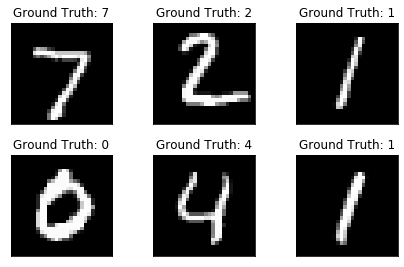

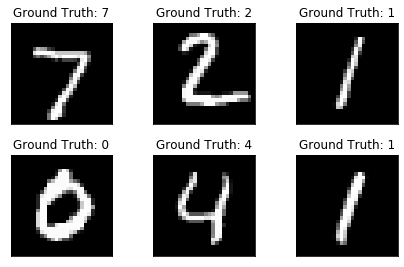

In [5]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [6]:
def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc
        
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    train_acc = []
    val_acc = []
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            #loss = F.nll_loss(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                train_acc.append(check_accuracy_part34(loader_train, model))
                print()
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                val_acc.append(check_accuracy_part34(loader_val, model))
                print()
    return train_acc, val_acc
                
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [7]:
n_epochs = 3
learning_rate = 0.01
momentum = 0.5
log_interval = 10

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, padding=0, stride=1, bias = True), #26x26
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.Conv2d(8, 8, kernel_size=3, padding=1, stride=1, bias = True), #26x26
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.Conv2d(8, 16, kernel_size=3, padding=1, stride=2, bias = True), #13x13
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, padding=1, stride=1, bias = True), #13x13
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, padding=1, stride=1, bias = True), #13x13
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2, bias = True), #7x7
    nn.BatchNorm2d(32),
    nn.Tanh(),
    nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=1, bias = True), #7x7
    nn.BatchNorm2d(32),
    nn.Tanh(),
    nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=1, bias = True), #7x7
    nn.BatchNorm2d(32),
    nn.Tanh(),
    nn.Conv2d(32, 8, kernel_size=3, padding=1, stride=1, bias = True), #7x7
    nn.BatchNorm2d(8),
    nn.Tanh(),
    Flatten(),
    nn.Linear(8*7*7, 10, bias = True),
    nn.Softmax(dim=1),
)

optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

train_acc, val_acc = train_part34(model, optimizer, epochs=5)

Iteration 0, loss = 2.3086
Checking accuracy on validation set
Got 6028 / 59000 correct (10.22)

Iteration 0, loss = 2.3086
Checking accuracy on validation set
Got 103 / 1000 correct (10.30)

Iteration 100, loss = 1.6063
Checking accuracy on validation set
Got 54475 / 59000 correct (92.33)

Iteration 100, loss = 1.6063
Checking accuracy on validation set
Got 948 / 1000 correct (94.80)

Iteration 200, loss = 1.5295
Checking accuracy on validation set
Got 56553 / 59000 correct (95.85)

Iteration 200, loss = 1.5295
Checking accuracy on validation set
Got 967 / 1000 correct (96.70)

Iteration 300, loss = 1.4782
Checking accuracy on validation set
Got 57311 / 59000 correct (97.14)

Iteration 300, loss = 1.4782
Checking accuracy on validation set
Got 982 / 1000 correct (98.20)

Iteration 400, loss = 1.4939
Checking accuracy on validation set
Got 57407 / 59000 correct (97.30)

Iteration 400, loss = 1.4939
Checking accuracy on validation set
Got 972 / 1000 correct (97.20)

Iteration 500, loss 

Iteration 200, loss = 1.4939
Checking accuracy on validation set
Got 58624 / 59000 correct (99.36)

Iteration 200, loss = 1.4939
Checking accuracy on validation set
Got 991 / 1000 correct (99.10)

Iteration 300, loss = 1.4634
Checking accuracy on validation set
Got 58623 / 59000 correct (99.36)

Iteration 300, loss = 1.4634
Checking accuracy on validation set
Got 990 / 1000 correct (99.00)

Iteration 400, loss = 1.4777
Checking accuracy on validation set
Got 58574 / 59000 correct (99.28)

Iteration 400, loss = 1.4777
Checking accuracy on validation set
Got 990 / 1000 correct (99.00)

Iteration 500, loss = 1.4775
Checking accuracy on validation set
Got 58613 / 59000 correct (99.34)

Iteration 500, loss = 1.4775
Checking accuracy on validation set
Got 990 / 1000 correct (99.00)

Iteration 600, loss = 1.4820
Checking accuracy on validation set
Got 58657 / 59000 correct (99.42)

Iteration 600, loss = 1.4820
Checking accuracy on validation set
Got 992 / 1000 correct (99.20)

Iteration 700, 

In [8]:
check_accuracy_part34(loader_test, model)

Checking accuracy on test set
Got 9915 / 10000 correct (99.15)


0.9915

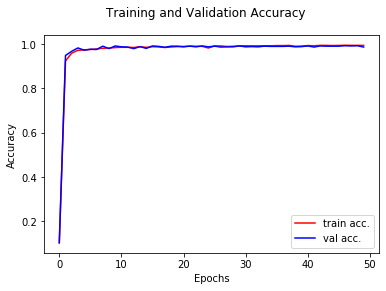

In [9]:
plt.figure()
plt.plot(np.arange(len(train_acc)), train_acc, c='r', label='train acc.')
plt.plot(np.arange(len(val_acc)), val_acc, c='b', label='val acc.')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.suptitle('Training and Validation Accuracy')
plt.legend()
plt.show()